In [1]:
import __init__
from __init__ import DATA_PATH, PACKAGE_PATH
from dce import DCE
from cluster import Cluster
import utilities
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Model
%matplotlib inline

Using TensorFlow backend.


In [2]:
from descriptor import rdkitDescriptors as rDesc

In [18]:
df = pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] = utilities.clean_out_of_bound(df['value (% BOD)'])
fps = rDesc.batch_compute_MACCSkeys(df['SMILES'])

df['bi_class_partition'] = utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
class_names = np.array(["nondegradable", "degradable"])

In [5]:
len(fps[0])

167

In [6]:
from dce import DCE

In [22]:
autoencoder_dims = [167, 120, 60]

n_cls = range(3,7)

losses = []
hidden_feats = []
y_preds = []
    
for n_cl in n_cls:
    dce = DCE(autoencoder_dims, n_clusters=n_cl, update_interval=20)
    cl_weight = 0.6
    dce.build_model(norm=False)
    print('Start to train model with num of clusters: ' + str(n_cl))
    loss_i = dce.train_model(data_train=fps,
                             clustering_loss='kld', decoder_loss='binary_crossentropy',
                             verbose=0,clustering_loss_weight=cl_weight,decay=10e-6)
    losses.append(loss_i)
    
    q, _ = dce.model.predict(fps)
    y_preds.append(q.argmax(1))
    
    encoder = Model(inputs=dce.model.input, 
                    outputs=dce.model.get_layer(name='embedding_layer').output)
    
    hidden_feats.append(encoder.predict(fps))
    
    print('Training finished and the results are recorded')

Start to train model with num of clusters: 3
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with num of clusters: 4
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with num of clusters: 5
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded
Start to train model with num of clusters: 6
0.0 < 0.0001
Reached tolerance threshold. Stopping training.
Training finished and the results are recorded


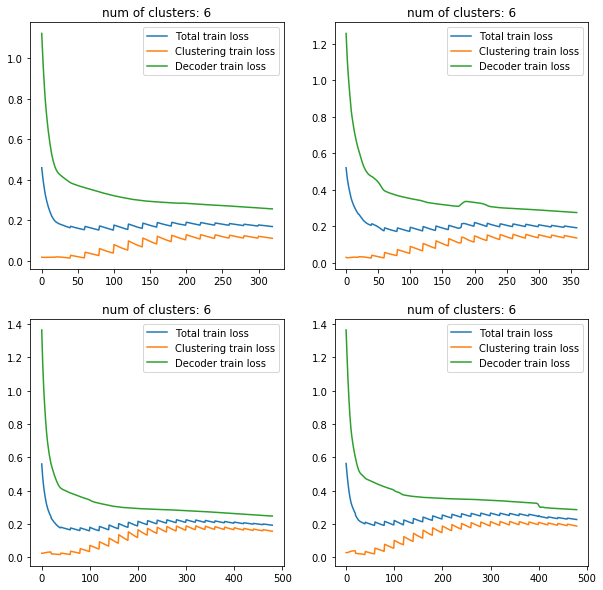

In [23]:
fig, ax =plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    row_i = int(i/2)
    column_j = i % 2

    ax[row_i][column_j].plot(losses[i][0],label='Total train loss')
    ax[row_i][column_j].plot(losses[i][1],label='Clustering train loss')
    ax[row_i][column_j].plot(losses[i][2],label='Decoder train loss')
    ax[row_i][column_j].legend()
    ax[row_i][column_j].set_title('num of clusters: ' + str(n_cl))

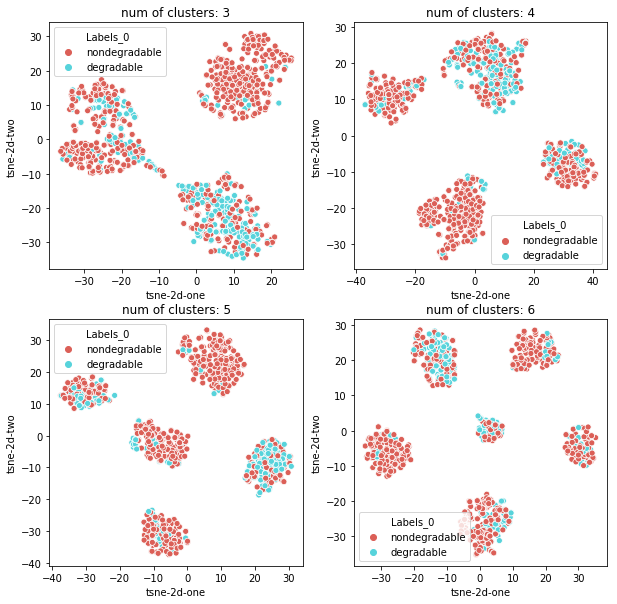

In [24]:
fig, ax =plt.subplots(2,2,figsize=(10,10))

for i in range(4):
    row_i = int(i/2)
    column_j = i % 2
    utilities.tsne_2d_visulization(
        input_feat=hidden_feats[i], 
        plot_labels=true_label_biclass,
        labels=class_names,
        verbose=0,
        ax=ax[row_i][column_j])

    ax[row_i][column_j].set_title('num of clusters: ' + str(n_cls[i]))

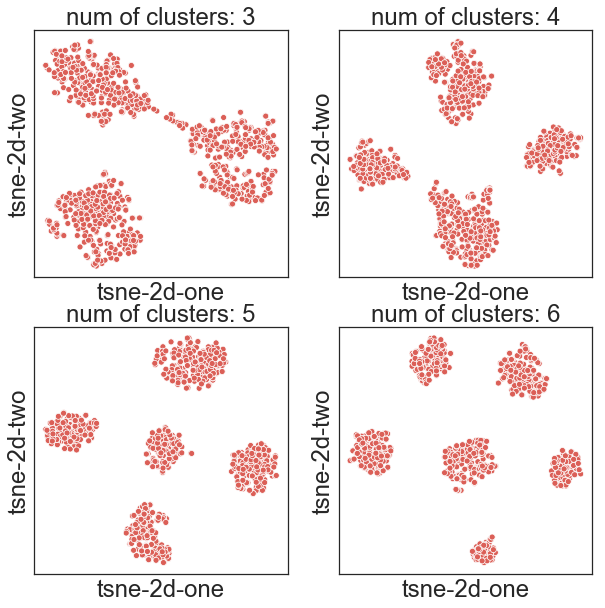

In [27]:
fig, ax =plt.subplots(2,2,figsize=(10,10))
sns.set(style='white', font_scale=2)


for i in range(4):
    row_i = int(i/2)
    column_j = i % 2
    utilities.tsne_2d_visulization(
        input_feat=hidden_feats[i], 
        plot_labels=np.zeros(len(hidden_feats[i])),
        verbose=0,
        ax=ax[row_i][column_j])

    ax[row_i][column_j].set_title('num of clusters: ' + str(n_cls[i]))
    ax[row_i][column_j].set_xticks([])
    ax[row_i][column_j].set_yticks([])
    ax[row_i][column_j].get_legend().remove()

plt.savefig('unsupervised_cluster_nums.pdf', bbox_inches='tight')